<a href="https://colab.research.google.com/github/sahils2607/COVID-Detection-in-CT-Scans/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports Required**

In [ ]:
import os
import PIL
import random
import copy
import math
from PIL import Image
import shutil
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import cv2

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets.folder import default_loader
from torchsummary import summary

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score,precision_score,recall_score

# **Preparing the Data**

In [ ]:
root_dir="/content/drive/MyDrive/archive"
positive_cases_path=os.path.join("/content/drive/MyDrive/archive/CT_COVID/")
negative_cases_path=os.path.join("/content/drive/MyDrive/archive/CT_NonCOVID/")

In [ ]:
positive_images=glob(os.path.join(positive_cases_path,'*.png'))
positive_images.extend(glob(os.path.join(positive_cases_path,"*.jpg")))
negative_images=glob(os.path.join(negative_cases_path,'*.png'))
negative_images.extend(glob(os.path.join(negative_cases_path,"*.jpg")))

In [ ]:
print('Number of positive Images :',len(positive_images))
print('Number of negative Images : ',len(negative_images))

Number of positive Images : 349
Number of negative Images :  397


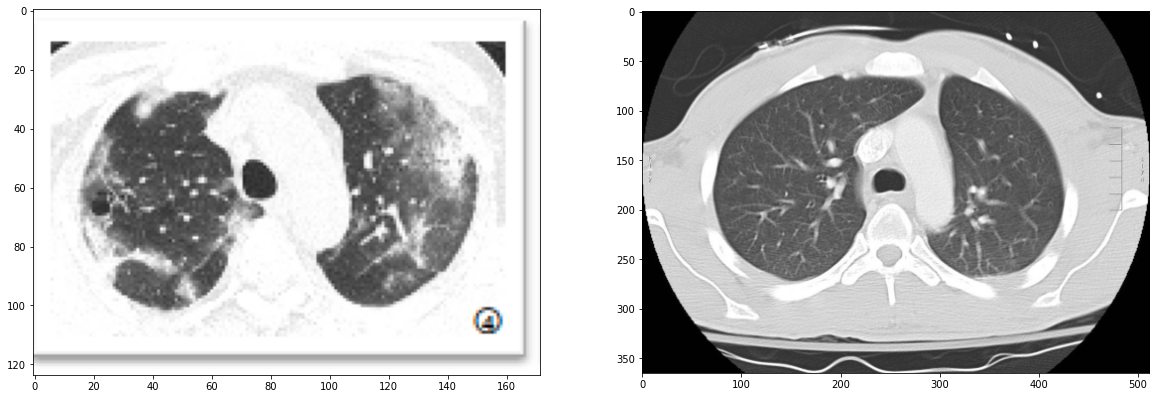

In [ ]:
image_sample_pos=PIL.Image.open(positive_images[73])
image_sample_neg=PIL.Image.open(negative_images[145])

pic=plt.figure(figsize=(20,20))
pic.add_subplot(1,2,1)
plt.imshow(image_sample_pos)
pic.add_subplot(1,2,2)
plt.imshow(image_sample_neg)

In [ ]:
covid={'class':'Covid',
       'images':positive_images}
noncovid={'class':'NonCovid',
'images':negative_images
}
## /content/drive/MyDrive

In [ ]:
subdirs=['/content/drive/MyDrive/train/','/content/drive/MyDrive/cval/','/content/drive/MyDrive/test/']
for subdir in subdirs:
  labeldirs=['Covid/','NonCovid/']
  for labeldir in labeldirs:
     newdir = subdir + labeldir
     os.makedirs(newdir, exist_ok=True)

In [ ]:
list1=list(range(0,len(positive_images)))
list2=list(range(0,len(negative_images)))
random.seed(59)
random.shuffle(list1)
random.seed(77)
random.shuffle(list2)

for group in [covid,noncovid]:
  frc=0.1
  number1=int(0.1*len(group['images']))
  listc=list2
  if group==covid:
    listc=list1
  print(listc)
  lenimages=len(listc)
  for x in range(number1):
    shutil.copy2(group['images'][listc[x]],'/content/drive/MyDrive/cval/'+group['class'])
  for x in range(number1,2*number1):
    shutil.copy2(group['images'][listc[x]],'/content/drive/MyDrive/test/'+group['class'])
  for x in range(2*number1,lenimages):
    shutil.copy2(group['images'][listc[x]],'/content/drive/MyDrive/train/'+group['class'])

[117, 208, 87, 314, 95, 149, 179, 268, 325, 286, 340, 308, 222, 342, 273, 300, 17, 132, 32, 206, 346, 177, 12, 292, 279, 317, 253, 55, 110, 343, 118, 28, 266, 194, 135, 327, 92, 252, 167, 312, 243, 36, 283, 138, 19, 187, 112, 116, 348, 128, 332, 220, 49, 213, 247, 215, 205, 113, 1, 127, 191, 238, 39, 108, 70, 96, 240, 140, 141, 302, 276, 198, 294, 184, 311, 324, 9, 131, 50, 267, 278, 210, 330, 244, 68, 225, 94, 169, 143, 57, 103, 62, 10, 295, 229, 21, 175, 305, 218, 18, 192, 84, 48, 71, 228, 316, 83, 320, 272, 139, 100, 336, 15, 281, 164, 14, 147, 168, 77, 212, 217, 97, 35, 86, 203, 201, 33, 339, 151, 120, 221, 265, 102, 200, 101, 255, 99, 199, 233, 216, 53, 72, 345, 171, 67, 3, 163, 137, 145, 133, 236, 40, 178, 121, 134, 315, 106, 89, 239, 46, 111, 52, 195, 224, 170, 125, 291, 196, 261, 256, 290, 148, 257, 162, 122, 319, 61, 301, 78, 142, 154, 250, 309, 157, 347, 165, 242, 26, 37, 263, 304, 158, 64, 34, 73, 297, 219, 63, 4, 227, 182, 337, 180, 146, 185, 0, 105, 211, 107, 307, 176, 249

In [ ]:
print('Positive Images in Cross Validation Set :',(len(os.listdir('/content/drive/MyDrive/cval/Covid'))))
print('Negative Images in Cross Validation Set :',(len(os.listdir('/content/drive/MyDrive/cval/NonCovid'))))
print('Positive Images in Test Set :',(len(os.listdir('/content/drive/MyDrive/test/Covid'))))
print('Negative Images in Test Set :',(len(os.listdir('/content/drive/MyDrive/test/NonCovid'))))
print('Positive Images in Train Set :',(len(os.listdir('/content/drive/MyDrive/train/Covid'))))
print('Negative Images in Train Set :',(len(os.listdir('/content/drive/MyDrive/train/NonCovid'))))

Positive Images in Cross Validation Set : 34
Negative Images in Cross Validation Set : 39
Positive Images in Test Set : 34
Negative Images in Test Set : 39
Positive Images in Train Set : 281
Negative Images in Train Set : 319


# **Building the Datasets and Databuilders**

In [ ]:
def CLAHE_transform(image_path):
  bgr = cv2.imread(image_path)
  lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
  lab_planes = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
  lab_planes[0] = clahe.apply(lab_planes[0])
  lab = cv2.merge(lab_planes)
  bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  return bgr

In [ ]:
def imshow(r,images):
  fig,axes=plt.subplots(r,2,figsize=(10,10))
  list1=list(range(0,len(images)))
  cols=['Before CLAHE','After CLAHE']
  random.shuffle(list1)
  n=0
  for ax, col in zip(axes[0], cols):
    ax.set_title(col,size='large')
  for i in range(r):
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 0].imshow(PIL.Image.open(images[list1[n]]))
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    im_pil = Image.fromarray(CLAHE_transform(images[list1[n]]))
    axes[i,1].imshow(im_pil)
    n += 1


Some Positive Images


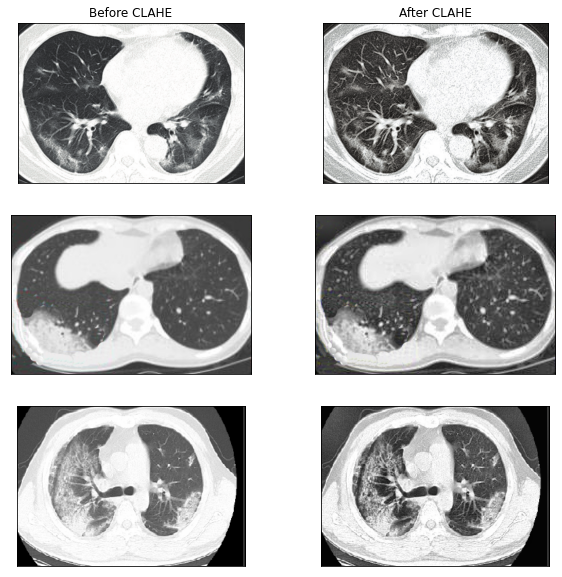

In [ ]:
print('Some Positive Images')
imshow(3,positive_images)

Some Negative Images


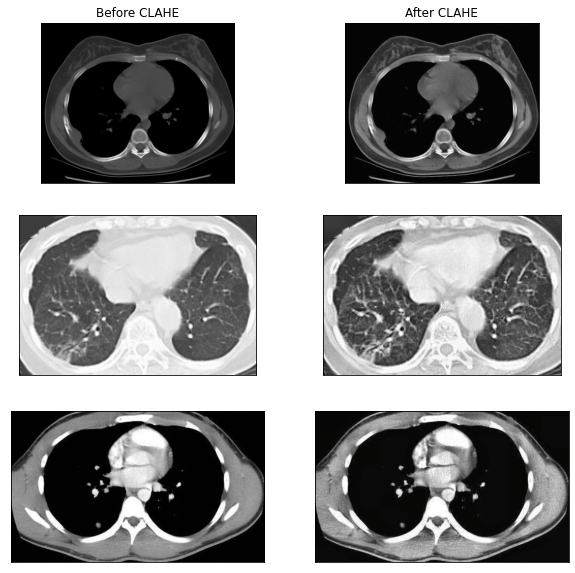

In [ ]:
print('Some Negative Images')
imshow(3,negative_images)

In [ ]:
transforms_basic = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(degrees=10),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [ ]:
class DatasetBuilder(datasets.ImageFolder):
  def __init__(self,root,loader=default_loader,is_valid_file=None,transform=None):
    super(DatasetBuilder, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file,transform=transform)
  def __getitem__(self,index):
    image_path,target=self.samples[index]
    bgr = CLAHE_transform(image_path)
    sample = torchvision.transforms.ToTensor()(bgr)
    sample=torchvision.transforms.ToPILImage()(sample)
    if self.transform:
      sample=self.transform(sample)
    return sample,target

In [ ]:
train_dataset=DatasetBuilder(root='/content/drive/MyDrive/train/',transform=transforms_basic)
train_dataloader=DataLoader(train_dataset,batch_size=25,shuffle=True)
cross_validation_dataset=DatasetBuilder(root='/content/drive/MyDrive/cval/',transform=transforms_basic)
cval_dataloader=DataLoader(cross_validation_dataset,batch_size=25,shuffle=True)

In [ ]:
#A simple python function to count number of items in each category
def bincounter(arr):
  z=[0,0]
  for x in arr:
    z[x]+=1;
  return z

In [ ]:
print(bincounter(train_dataset.targets))

[281, 319]


In [ ]:

print(bincounter(cross_validation_dataset.targets))

[34, 39]


In [ ]:
def get_number_correct(prediction,labels,device):
  return prediction.to(device).argmax(dim=1).eq(labels.to(device)).sum().item()





# **Function for Training**



In [ ]:
#Member Function to train a Network on the Dataset
def trainer(train_dataset,cross_validation_dataset,optimizer,num_epochs,model,checkpoint_path_models,device,scheduler):
  evaluater=[]
  min_val_loss=1e18 # to track minimum cross validation loss for purpose of early stopping
  epochs_no_improve=0 # To track number of epochs for which no improvement is made
  model.to(device)
  threshold_epochs=10
 ### checkpoint_path_models='model_resnet16.pth'

  for epoch in range(num_epochs):
    print('Epoch {} starts........'.format(epoch))
    total_train_loss_epoch=0
    total_crossval_loss_epoch=0
    total_correct_epoch=0
    total_correct_epoch_train=0
    train_dataloader=DataLoader(train_dataset,batch_size=25,shuffle=True)
    cval_dataloader=DataLoader(cross_validation_dataset,batch_size=25,shuffle=True)
    z1=0 # Total Number of training samples tracker
    z2=0 # Total Number of Cross val samples tracker
    for images,labels in iter(train_dataloader):
      images=images.to(device)
      labels=labels.to(device)
      z1+=len(labels)
      optimizer.zero_grad()
      out=model(images)
      loss=F.cross_entropy(out,labels)
      
      loss.backward()
      optimizer.step()
      
      total_train_loss_epoch+=loss.item()*train_dataloader.batch_size
      total_correct_epoch_train+=get_number_correct(out,labels,device)

    for samples,tags in iter(cval_dataloader):
      model.eval()
      with torch.no_grad():
        samples=samples.to(device)
        tags=tags.to(device)
        z2+=len(tags)
        preds=model(samples)
        cval_loss=F.cross_entropy(preds,tags)
        total_crossval_loss_epoch+=cval_loss.item()*cval_dataloader.batch_size

        total_correct_epoch+=get_number_correct(preds,tags,device)
    
    total_train_loss_epoch/=len(train_dataset)
    total_crossval_loss_epoch/=len(cross_validation_dataset)

    #Check for Early Stopping or Saving the model
    if total_crossval_loss_epoch<min_val_loss and epoch>0:
      #Save the model
      torch.save(model.state_dict(),checkpoint_path_models)
      print("Model saved at Epoch Number {}".format(epoch))
      epochs_no_improve=0
      min_val_loss=total_crossval_loss_epoch
    else:
      epochs_no_improve+=1
      if epochs_no_improve==threshold_epochs:
        print('Early Stopping !', 'Epoch Number : {}'.format(epoch))
        #Load the Model
        ##model=torch.load(checkpoint_path_models) ##isko theek krna h abhi
    if scheduler is not 0:
      scheduler.step()
    print("Cross Validation Loss :  {} " .format(total_crossval_loss_epoch),"Cross Validation Accuracy : {} ".format(total_correct_epoch/z2))
    ###my_lr_scheduler.step()
    evaluater.append([epoch,total_train_loss_epoch,total_crossval_loss_epoch,total_correct_epoch_train/z1,total_correct_epoch/z2])
  # print(evaluater[epoch])
  df=pd.DataFrame(evaluater,columns=['Epoch','Training_loss','Validation_loss','Training_Accuracy','Validation_Accuracy'])
  return df


In [ ]:
def model_performance_plotter(df1):
  ax=plt.gca()
  df1.plot(kind='line',x='Epoch',y='Training_loss',ax=ax)
  df1.plot(kind='line',x='Epoch',y='Validation_loss',color='Red',ax=ax)
  plt.show()


  ax=plt.gca()
  df1.plot(kind='line',x='Epoch',y='Training_Accuracy',ax=ax)
  df1.plot(kind='line',x='Epoch',y='Validation_Accuracy',color='Red',ax=ax)
  plt.show()


# **Trying Different Models** 

## **Resnet18**

In [ ]:
model_resnet16_pretrained_untuned=torchvision.models.resnet18(pretrained=True)
for name,param in model_resnet16_pretrained_untuned.named_parameters():
  if("bn" not in name):
     param.requires_grad=False
model_resnet16_pretrained_untuned.to('cpu')
print(summary(model_resnet16_pretrained_untuned,(3,224,224),28,'cpu'))
model_resnet16_pretrained_untuned.fc=nn.Sequential(
     nn.Linear(512, 256), 
     nn.ReLU(), 
     nn.Dropout(0.4),
     nn.Linear(256, 2),                   
     nn.LogSoftmax(dim=1)
)

## Here untrained model is created which can be copied later on according to need

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [28, 64, 112, 112]           9,408
       BatchNorm2d-2         [28, 64, 112, 112]             128
              ReLU-3         [28, 64, 112, 112]               0
         MaxPool2d-4           [28, 64, 56, 56]               0
            Conv2d-5           [28, 64, 56, 56]          36,864
       BatchNorm2d-6           [28, 64, 56, 56]             128
              ReLU-7           [28, 64, 56, 56]               0
            Conv2d-8           [28, 64, 56, 56]          36,864
       BatchNorm2d-9           [28, 64, 56, 56]             128
             ReLU-10           [28, 64, 56, 56]               0
       BasicBlock-11           [28, 64, 56, 56]               0
           Conv2d-12           [28, 64, 56, 56]          36,864
      BatchNorm2d-13           [28, 64, 56, 56]             128
             ReLU-14           [28, 64

In [ ]:
model_4=copy.deepcopy(model_resnet16_pretrained_untuned)
optimizer=optim.Adam(model_4.parameters(),lr=0.0011,weight_decay=0.01)
if torch.cuda.is_available():
  device='cuda'
else:
  device='cpu'
print(device)
checkpoint_path='resnet16_CLAHE_lrfinderwala.pth'
df8=trainer(train_dataset,cross_validation_dataset,optimizer,30,model_4,checkpoint_path,device)
df8

cuda
Epoch 0 starts........
Model saved at Epoch Number 0
Cross Validation Loss :  0.7575037748846289  Cross Validation Accuracy : 0.589041095890411 
Epoch 1 starts........
Model saved at Epoch Number 1
Cross Validation Loss :  0.4688338670012069  Cross Validation Accuracy : 0.821917808219178 
Epoch 2 starts........
Cross Validation Loss :  0.47003118550940737  Cross Validation Accuracy : 0.8082191780821918 
Epoch 3 starts........
Model saved at Epoch Number 3
Cross Validation Loss :  0.46551123975890957  Cross Validation Accuracy : 0.8356164383561644 
Epoch 4 starts........
Cross Validation Loss :  0.6419255513034455  Cross Validation Accuracy : 0.726027397260274 
Epoch 5 starts........
Model saved at Epoch Number 5
Cross Validation Loss :  0.38972220396342344  Cross Validation Accuracy : 0.7945205479452054 
Epoch 6 starts........
Cross Validation Loss :  0.5319049301212782  Cross Validation Accuracy : 0.7945205479452054 
Epoch 7 starts........
Cross Validation Loss :  0.4937069158848

,Epoch,Training_loss,Validation_loss,Training_Accuracy,Validation_Accuracy
0,0,0.664448,0.757504,0.635000,0.589041
1,1,0.520401,0.468834,0.730000,0.821918
2,2,0.465693,0.470031,0.783333,0.808219
3,3,0.375452,0.465511,0.831667,0.835616
4,4,0.314739,0.641926,0.855000,0.726027
5,5,0.298564,0.389722,0.876667,0.794521
6,6,0.257739,0.531905,0.885000,0.794521
7,7,0.211241,0.493707,0.916667,0.808219
8,8,0.379407,0.465037,0.846667,0.821918
9,9,0.235218,0.410034,0.900000,0.794521


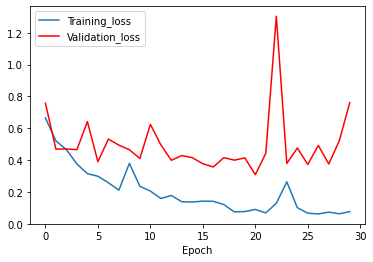

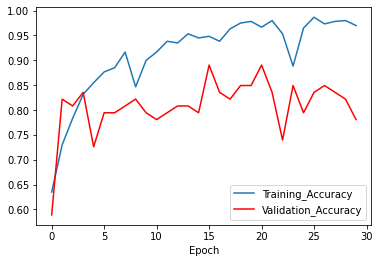

In [ ]:
model_performance_plotter(df8)

Epoch 0 starts........
Model saved at Epoch Number 0
Cross Validation Loss :  0.5806697966301277  Cross Validation Accuracy : 0.6986301369863014 
Epoch 1 starts........
Model saved at Epoch Number 1
Cross Validation Loss :  0.4564912658031673  Cross Validation Accuracy : 0.7808219178082192 
Epoch 2 starts........
Cross Validation Loss :  0.538547010454413  Cross Validation Accuracy : 0.7671232876712328 
Epoch 3 starts........
Cross Validation Loss :  0.46747195189946317  Cross Validation Accuracy : 0.8493150684931506 
Epoch 4 starts........
Model saved at Epoch Number 4
Cross Validation Loss :  0.4323631525039673  Cross Validation Accuracy : 0.8767123287671232 
Epoch 5 starts........
Model saved at Epoch Number 5
Cross Validation Loss :  0.4193326994164349  Cross Validation Accuracy : 0.8082191780821918 
Epoch 6 starts........
Cross Validation Loss :  0.5119543165376742  Cross Validation Accuracy : 0.821917808219178 
Epoch 7 starts........
Model saved at Epoch Number 7
Cross Validation

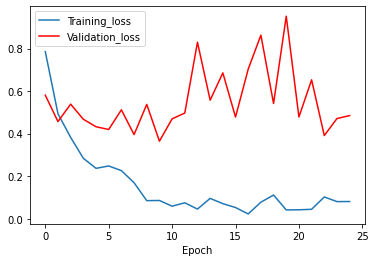

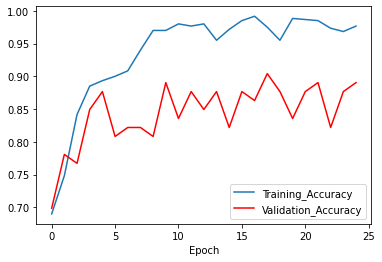

In [ ]:
model_4.load_state_dict(torch.load(checkpoint_path))
for param in model_4.parameters():
  if param.requires_grad==False:
      param.requires_grad=True
optimizer=optim.Adam(model_4.parameters(),lr=0.0000615,weight_decay=0.01)
if torch.cuda.is_available():
  device='cuda'
else:
  device='cpu'
df2=trainer(train_dataset,cross_validation_dataset,optimizer,25,model_4,checkpoint_path,device)
df2
model_performance_plotter(df2)

## **VGG 121**

In [ ]:
model_vgg_pretrained_untuned=torchvision.models.vgg16(pretrained=True)
for param in model_vgg_pretrained_untuned.parameters():
  param.requires_grad=False
model_vgg_pretrained_untuned.to('cpu')
print(summary(model_vgg_pretrained_untuned,(3,224,224),28,'cpu'))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [28, 64, 224, 224]           1,792
              ReLU-2         [28, 64, 224, 224]               0
            Conv2d-3         [28, 64, 224, 224]          36,928
              ReLU-4         [28, 64, 224, 224]               0
         MaxPool2d-5         [28, 64, 112, 112]               0
            Conv2d-6        [28, 128, 112, 112]          73,856
              ReLU-7        [28, 128, 112, 112]               0
            Conv2d-8        [28, 128, 112, 112]         147,584
              ReLU-9        [28, 128, 112, 112]               0
        MaxPool2d-10          [28, 128, 56, 56]               0
           Conv2d-11          [28, 256, 56, 56]         295,168
             ReLU-12          [28, 256, 56, 56]               0
           Conv2d-13          [28, 256, 56, 56]         590,080
             ReLU-14          [28, 256

In [ ]:
model_vgg_pretrained_untuned.classifier = nn.Sequential(*[model_vgg_pretrained_untuned.classifier[i] for i in range(4)])
model_vgg_pretrained_untuned.classifier[3]=nn.Sequential(
    nn.Linear(4096,1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,64),
    nn.ReLU(),
    nn.Dropout(.40),
    nn.Linear(64,2),
    nn.LogSoftmax(dim=1)
)

In [ ]:
device='cpu'
if(torch.cuda.is_available()):
  device='cuda'

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0 starts........
Adjusting learning rate of group 0 to 1.0000e-03.
Cross Validation Loss :  0.563337653875351  Cross Validation Accuracy : 0.6438356164383562 
Epoch 1 starts........
Model saved at Epoch Number 1
Adjusting learning rate of group 0 to 1.0000e-03.
Cross Validation Loss :  0.4226716107701602  Cross Validation Accuracy : 0.8082191780821918 
Epoch 2 starts........
Model saved at Epoch Number 2
Adjusting learning rate of group 0 to 1.0000e-03.
Cross Validation Loss :  0.39265442588557936  Cross Validation Accuracy : 0.8082191780821918 
Epoch 3 starts........
Adjusting learning rate of group 0 to 1.0000e-03.
Cross Validation Loss :  0.4719014241270823  Cross Validation Accuracy : 0.7808219178082192 
Epoch 4 starts........
Adjusting learning rate of group 0 to 8.0000e-04.
Cross Validation Loss :  0.4063680870075748  Cross Validation Accuracy : 0.8082191780821918 
Epoch 5 starts........
Model saved at Epoch Number 5
Adjusti

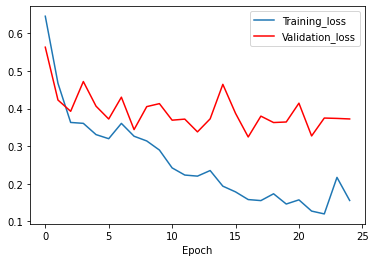

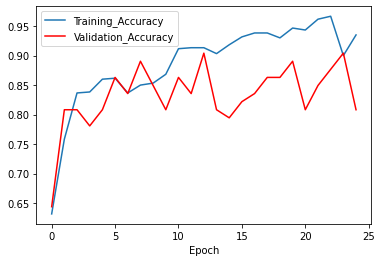

In [ ]:
model_vgg1=copy.deepcopy(model_vgg_pretrained_untuned)
optimizer=optim.Adam(model_vgg1.parameters(),lr=0.001,weight_decay=0.02)
checkpoint_path='vgg16_1n.pth'
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8, last_epoch=-1, verbose=True)
df_vgg1=trainer(train_dataset,cross_validation_dataset,optimizer,25,model_vgg1,checkpoint_path,device,scheduler)
model_performance_plotter(df_vgg1)

In [ ]:
model_vgg1=copy.deepcopy(model_vgg_pretrained_untuned)
model_vgg1.load_state_dict(torch.load(checkpoint_path))
optimizer=optim.Adam(model_vgg1.parameters(),lr=0.0006,weight_decay=0.1)
checkpoint_path11='vgg16_2n.pth'
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9, last_epoch=-1, verbose=True)
df_vgg11=trainer(train_dataset,cross_validation_dataset,optimizer,5,model_vgg1,checkpoint_path11,device,scheduler)


Adjusting learning rate of group 0 to 6.0000e-04.
Epoch 0 starts........
Adjusting learning rate of group 0 to 6.0000e-04.
Cross Validation Loss :  0.46442244967369184  Cross Validation Accuracy : 0.7671232876712328 
Epoch 1 starts........
Model saved at Epoch Number 1
Adjusting learning rate of group 0 to 5.4000e-04.
Cross Validation Loss :  0.4355634626460402  Cross Validation Accuracy : 0.821917808219178 
Epoch 2 starts........
Model saved at Epoch Number 2
Adjusting learning rate of group 0 to 5.4000e-04.
Cross Validation Loss :  0.35026506201861657  Cross Validation Accuracy : 0.8356164383561644 
Epoch 3 starts........
Adjusting learning rate of group 0 to 4.8600e-04.
Cross Validation Loss :  0.4300103101828327  Cross Validation Accuracy : 0.8493150684931506 
Epoch 4 starts........
Model saved at Epoch Number 4
Adjusting learning rate of group 0 to 4.8600e-04.
Cross Validation Loss :  0.32966718179722354  Cross Validation Accuracy : 0.8493150684931506 


In [ ]:
model_vgg1.load_state_dict(torch.load(checkpoint_path))
for param in model_vgg1.parameters():
  if param.requires_grad==False:
      param.requires_grad=True


In [ ]:
optimizer=optim.Adam(model_vgg1.parameters(),lr=0.00001,weight_decay=0.3)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8, last_epoch=-1, verbose=True)
checkpoint_path2='vggfinal.pth'
df2=trainer(train_dataset,cross_validation_dataset,optimizer,15,model_vgg1,checkpoint_path2,device,scheduler)
model_performance_plotter(df2)

## **DenseNet 121**

In [ ]:
model_densenet_pretrained_untuned=torchvision.models.densenet121(pretrained=True)
for name,param in model_densenet_pretrained_untuned.named_parameters():
  if("norm" not in name):
     param.requires_grad=False
model_densenet_pretrained_untuned.to('cuda')

In [ ]:
model_densenet_pretrained_untuned.classifier=nn.Sequential(
    nn.Linear(1024,256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128,2),
    nn.LogSoftmax(dim=1)
)

In [ ]:
densenet_total_params = sum(p.numel() for p in model_densenet_pretrained_untuned.parameters())
print('Total number of Parameters in Densenet Network : {}'.format(densenet_total_params ))
densenet_total_params_train = sum(p.numel() for p in model_densenet_pretrained_untuned.parameters() if p.requires_grad)
print('Total number of Trainable Parameters in Densenet Network : {}'.format(densenet_total_params_train ))

Total number of Parameters in Densenet Network : 7249410
Total number of Trainable Parameters in Densenet Network : 379202


**Training**

In [ ]:
device='cpu'
if(torch.cuda.is_available()):
  device='cuda'

Epoch 0 starts........
Model saved at Epoch Number 0
Cross Validation Loss :  0.6905174826922482  Cross Validation Accuracy : 0.6301369863013698 
Epoch 1 starts........
Model saved at Epoch Number 1
Cross Validation Loss :  0.5592200547864993  Cross Validation Accuracy : 0.7123287671232876 
Epoch 2 starts........
Model saved at Epoch Number 2
Cross Validation Loss :  0.5228256628121415  Cross Validation Accuracy : 0.7808219178082192 
Epoch 3 starts........
Cross Validation Loss :  0.6115097501506545  Cross Validation Accuracy : 0.6986301369863014 
Epoch 4 starts........
Cross Validation Loss :  0.5891297880100878  Cross Validation Accuracy : 0.7123287671232876 
Epoch 5 starts........
Model saved at Epoch Number 5
Cross Validation Loss :  0.4887091174517592  Cross Validation Accuracy : 0.7808219178082192 
Epoch 6 starts........
Cross Validation Loss :  0.5001504739669904  Cross Validation Accuracy : 0.7534246575342466 
Epoch 7 starts........
Model saved at Epoch Number 7
Cross Validatio

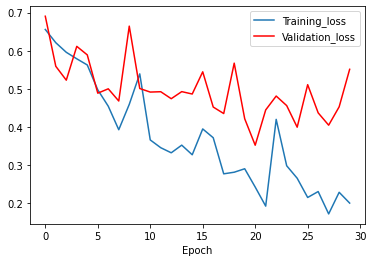

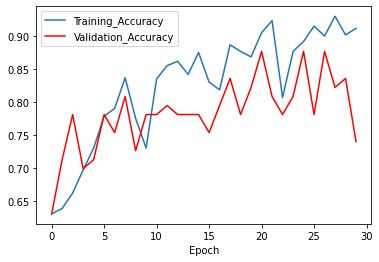

In [ ]:
model_dt1=copy.deepcopy(model_densenet_pretrained_untuned)
optimizer=optim.Adam(model_dt1.parameters(),lr=0.0012,weight_decay=0.01)
checkpoint_path='densenet121_1.pth'
df_dt1=trainer(train_dataset,cross_validation_dataset,optimizer,30,model_dt1,checkpoint_path,device)
model_performance_plotter(df_dt1)

Epoch 0 starts........
Model saved at Epoch Number 0
Cross Validation Loss :  0.4432567382512027  Cross Validation Accuracy : 0.821917808219178 
Epoch 1 starts........
Model saved at Epoch Number 1
Cross Validation Loss :  0.40141085086211764  Cross Validation Accuracy : 0.8493150684931506 
Epoch 2 starts........
Model saved at Epoch Number 2
Cross Validation Loss :  0.3444733991198344  Cross Validation Accuracy : 0.8767123287671232 
Epoch 3 starts........
Cross Validation Loss :  0.5264126682934696  Cross Validation Accuracy : 0.7945205479452054 
Epoch 4 starts........
Model saved at Epoch Number 4
Cross Validation Loss :  0.3218854790272778  Cross Validation Accuracy : 0.863013698630137 
Epoch 5 starts........
Cross Validation Loss :  0.5843379675117257  Cross Validation Accuracy : 0.7945205479452054 
Epoch 6 starts........
Cross Validation Loss :  0.4685449681869925  Cross Validation Accuracy : 0.7808219178082192 
Epoch 7 starts........
Cross Validation Loss :  0.4108601568700516  C

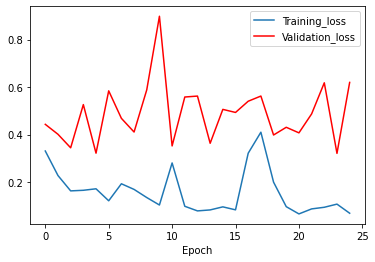

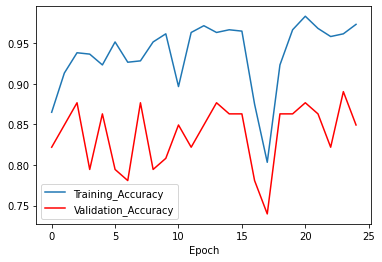

In [ ]:
model_dt1.load_state_dict(torch.load('/content/densenet121_1.pth'))
for param in model_dt1.parameters():
  if param.requires_grad==False:
      param.requires_grad=True
optimizer=optim.Adam(model_dt1.parameters(),lr=0.0001,weight_decay=0.01)
checkpoint_path='densenet121_2.pth'
df_dt1=trainer(train_dataset,cross_validation_dataset,optimizer,25,model_dt1,checkpoint_path,device)
model_performance_plotter(df_dt1)

# **Results On Test Set**

In [ ]:
# A python function to get results on test set
def testset_results(model,test_dataset,device):
  model.to(device)
  model.eval()
  test_dataloader=DataLoader(test_dataset,batch_size=5,shuffle=False)
  actuals = []
  predictions = []
  with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
  return [i.item() for i in actuals], [i.item() for i in predictions]

In [ ]:
def test_class_probabilities(model, device, test_loader):
    model.to(device)
    test_dataloader=DataLoader(test_dataset,batch_size=5,shuffle=False)
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction)==0)
            probabilities.extend(np.exp(output[:,0]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

In [ ]:
transforms_basic_1 = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


##**Resnet 18 model**

In [ ]:
model_resnet18=torchvision.models.resnet18(pretrained=False)
model_resnet18.fc=nn.Sequential(
     nn.Linear(512, 256), 
     nn.ReLU(), 
     nn.Dropout(0.4),
     nn.Linear(256, 2),                   
     nn.LogSoftmax(dim=1)
)
device='cuda'
model_resnet18.load_state_dict(torch.load('/content/drive/MyDrive/project_covid_small_results/resnet16_CLAHE_lrfinderwala_afterfinetune_89.pth'))


<All keys matched successfully>

In [ ]:
cross_validation_dataset

In [ ]:
model_resnet18.load_state_dict(torch.load('/content/drive/MyDrive/project_covid_small_results/resnet16_CLAHE_lrfinderwala_afterfinetune_89.pth'))

<All keys matched successfully>

In [ ]:
# Results on testset after finetuned
labels,predictions=testset_results(model_resnet18,test_dataset,device)
print('Confusion matrix:')
print(confusion_matrix(labels, predictions))
print('F1 score: %f' % f1_score(labels, predictions))
print('Accuracy score: %f' % accuracy_score(labels, predictions))
print('Precision Score: {}'.format(precision_score(labels,predictions)))
print('Recall:{}'.format(recall_score(labels,predictions)))

Confusion matrix:
[[29  5]
 [ 3 36]]
F1 score: 0.900000
Accuracy score: 0.890411
Precision Score: 0.8780487804878049
Recall:0.9230769230769231


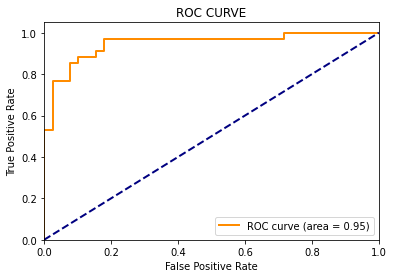

In [ ]:
device='cpu'
actuals, class_probabilities = test_class_probabilities(model_resnet18, device, test_dataset)

fpr, tpr, _ = metrics.roc_curve(actuals, class_probabilities)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE' )
plt.legend(loc="lower right")
plt.show()

## **VGG 121**

In [ ]:
model_vgg121=torchvision.models.vgg16(pretrained=False)
model_vgg121.classifier = nn.Sequential(*[model_vgg121.classifier[i] for i in range(4)])
model_vgg121.classifier[3]=nn.Sequential(
    nn.Linear(4096,1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,64),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(64,2),
    nn.LogSoftmax(dim=1)
)
model_vgg121.load_state_dict(torch.load('/content/drive/MyDrive/project_covid_small_results/vggfinal.pth'))

<All keys matched successfully>

In [ ]:
#Results on test after fine tuning
labels,predictions=testset_results(model_vgg121,test_dataset,device)
print('Confusion matrix:')
print(confusion_matrix(labels, predictions))
print('F1 score: %f' % f1_score(labels, predictions))
print('Accuracy score: %f' % accuracy_score(labels, predictions))
print('Precision Score: {}'.format(precision_score(labels,predictions)))
print('Recall:{}'.format(recall_score(labels,predictions)))

Confusion matrix:
[[29  5]
 [ 3 36]]
F1 score: 0.900000
Accuracy score: 0.890411
Precision Score: 0.8780487804878049
Recall:0.9230769230769231


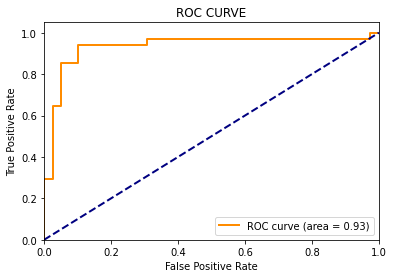

In [ ]:
device='cpu'
actuals, class_probabilities = test_class_probabilities(model_vgg121, device, test_dataset)

fpr, tpr, _ = metrics.roc_curve(actuals, class_probabilities)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE' )
plt.legend(loc="lower right")
plt.show()

## **DenseNet 121**

In [ ]:
model_densenet=torchvision.models.densenet121(pretrained=False)
model_densenet.classifier=nn.Sequential(
    nn.Linear(1024,256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128,2),
    nn.LogSoftmax(dim=1)
)
model_densenet.load_state_dict(torch.load('/content/drive/MyDrive/project_covid_small_results/densenet121_2.pth'))

<All keys matched successfully>

In [ ]:
labels,predictions=testset_results(model_densenet,test_dataset,device)
print('Confusion matrix:')
print(confusion_matrix(labels, predictions))
print('F1 score: %f' % f1_score(labels, predictions))
print('Accuracy score: %f' % accuracy_score(labels, predictions))
print('Precision Score: {}'.format(precision_score(labels,predictions)))
print('Recall:{}'.format(recall_score(labels,predictions)))

Confusion matrix:
[[32  2]
 [11 28]]
F1 score: 0.811594
Accuracy score: 0.821918
Precision Score: 0.9333333333333333
Recall:0.717948717948718


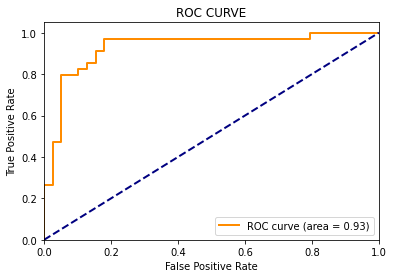

In [ ]:
device='cpu'
actuals, class_probabilities = test_class_probabilities(model_densenet, device, test_dataset)

fpr, tpr, _ = metrics.roc_curve(actuals, class_probabilities)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE' )
plt.legend(loc="lower right")
plt.show()

##**Final ROC Curve**

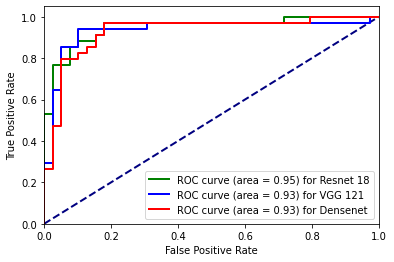

In [ ]:
plt.figure(0).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')


actuals, class_probabilities = test_class_probabilities(model_resnet18, device, test_dataset)
fpr, tpr, _ = metrics.roc_curve(actuals, class_probabilities)
roc_auc = metrics.auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='green',
         lw=lw, label='ROC curve (area = %0.2f) for Resnet 18' % roc_auc)

actuals, class_probabilities = test_class_probabilities(model_vgg121, device, test_dataset)
fpr, tpr, _ = metrics.roc_curve(actuals, class_probabilities)
roc_auc = metrics.auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='blue',
         lw=lw, label='ROC curve (area = %0.2f) for VGG 121 ' % roc_auc)



actuals, class_probabilities = test_class_probabilities(model_densenet, device, test_dataset)
fpr, tpr, _ = metrics.roc_curve(actuals, class_probabilities)
roc_auc = metrics.auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f) for Densenet' % roc_auc)

plt.legend(loc=0)

#**Plotting Models**

In [ ]:
!sudo apt install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [ ]:
!pip3 install graphviz
!pip install hiddenlayer

In [ ]:
import hiddenlayer as hl

### **Resnet 18**

/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


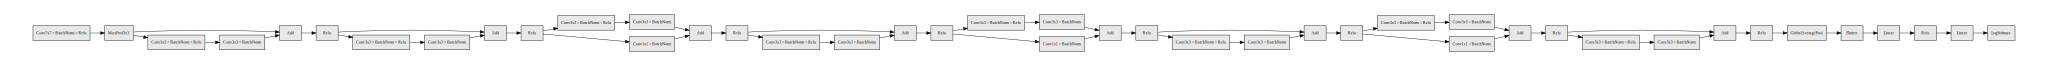

In [ ]:
model = model_resnet18

# Rather than using the default transforms, build custom ones to group
# nodes of residual and bottleneck blocks.
transforms = [
    # Fold Conv, BN, RELU layers into one
    hl.transforms.Fold("Conv > BatchNorm > Relu", "ConvBnRelu"),
    # Fold Conv, BN layers together
    hl.transforms.Fold("Conv > BatchNorm", "ConvBn"),
    # Fold bottleneck blocks
    hl.transforms.Fold("""
        ((ConvBnRelu > ConvBnRelu > ConvBn) | ConvBn) > Add > Relu
        """, "BottleneckBlock", "Bottleneck Block"),
    # Fold residual blocks
    hl.transforms.Fold("""ConvBnRelu > ConvBnRelu > ConvBn > Add > Relu""",
                       "ResBlock", "Residual Block"),
    # Fold repeated blocks
    hl.transforms.FoldDuplicates(),
]

# Display graph using the transforms above
hl.build_graph(model, torch.zeros([1, 3, 224, 224]), transforms=transforms)

/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


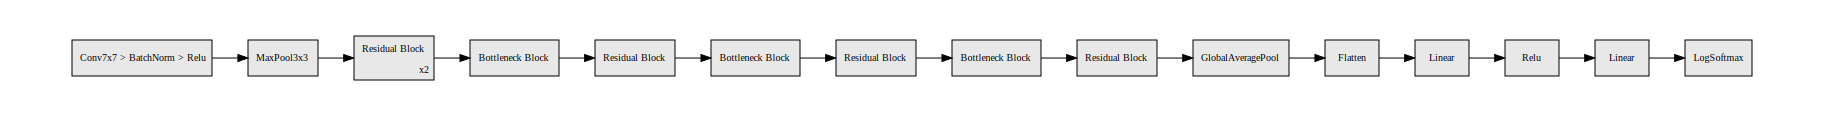

In [ ]:
transforms = [
    # Fold Conv, BN, RELU layers into one
    hl.transforms.Fold("Conv > BatchNorm > Relu", "ConvBnRelu"),
    # Fold Conv, BN layers together
    hl.transforms.Fold("Conv > BatchNorm", "ConvBn"),
  ##  hl.transforms.Fold("Conv > BatchNorm > Relu> Conv> BatchNorm", "ConvBnReluConvBn"),
    # Fold bottleneck blocks
    hl.transforms.Fold("""
        ((ConvBnRelu > ConvBn) | ConvBn) > Add > Relu
        """, "BottleneckBlock", "Bottleneck Block"),
    # Fold residual blocks
    hl.transforms.Fold("""ConvBnRelu > ConvBn > Add > Relu""",
                       "ResBlock", "Residual Block"),
    # Fold repeated blocks
    hl.transforms.FoldDuplicates(),
]

# Display graph using the transforms above
hl.build_graph(model, torch.zeros([1, 3, 224, 224]), transforms=transforms)

## **VGG 121**

/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


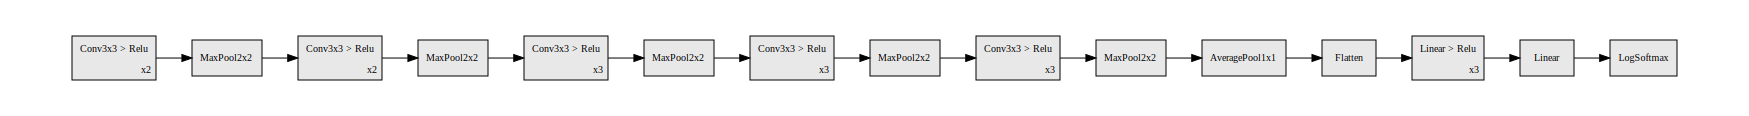

In [ ]:
model = model_vgg121
hl.build_graph(model, torch.zeros([1, 3, 224, 224]))

## **Densenet121**

In [ ]:
model = model_densenet
hl.build_graph(model, torch.zeros([1, 3, 224, 224]))